I decided to treat this as a classification problem by creating a new binary
variable affair (did the woman have at least one affair?) and trying to
predict the classification for each woman.

### Dataset:
The dataset I chose is the affairs dataset that comes with Statsmodels. It
was derived from a survey of women in 1974 by Redbook magazine, in
which married women were asked about their participation in extramarital
affairs. More information about the study is available in a 1978 paper from
the Journal of Political Economy.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from patsy import dmatrices
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,roc_curve,roc_auc_score


In [2]:
data = sm.datasets.fair.load_pandas().data

In [3]:
data

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666
...,...,...,...,...,...,...,...,...,...
6361,5.0,32.0,13.0,2.0,3.0,17.0,4.0,3.0,0.000000
6362,4.0,32.0,13.0,1.0,1.0,16.0,5.0,5.0,0.000000
6363,5.0,22.0,2.5,0.0,2.0,14.0,3.0,1.0,0.000000
6364,5.0,32.0,6.0,1.0,3.0,14.0,3.0,4.0,0.000000


In [4]:
data.isnull().sum()

rate_marriage      0
age                0
yrs_married        0
children           0
religious          0
educ               0
occupation         0
occupation_husb    0
affairs            0
dtype: int64

In [5]:
# Adding 'affair' column: 1 represents having affair, 0 doesn't
data['affair']= (data.affairs>0).astype(int)

In [6]:
data.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1


In [7]:
data.describe()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
count,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000
mean,4.109645,29.082862,9.009425,1.396874,2.426170,14.209865,3.424128,3.850141,0.705374,0.322495
std,0.961430,6.847882,7.280120,1.433471,0.878369,2.178003,0.942399,1.346435,2.203374,0.467468
min,1.000000,17.500000,0.500000,0.000000,1.000000,9.000000,1.000000,1.000000,0.000000,0.000000
25%,4.000000,22.000000,2.500000,0.000000,2.000000,12.000000,3.000000,3.000000,0.000000,0.000000
50%,4.000000,27.000000,6.000000,1.000000,2.000000,14.000000,3.000000,4.000000,0.000000,0.000000
75%,5.000000,32.000000,16.500000,2.000000,3.000000,16.000000,4.000000,5.000000,0.484848,1.000000
max,5.000000,42.000000,23.000000,5.500000,4.000000,20.000000,6.000000,6.000000,57.599991,1.000000


### EDA

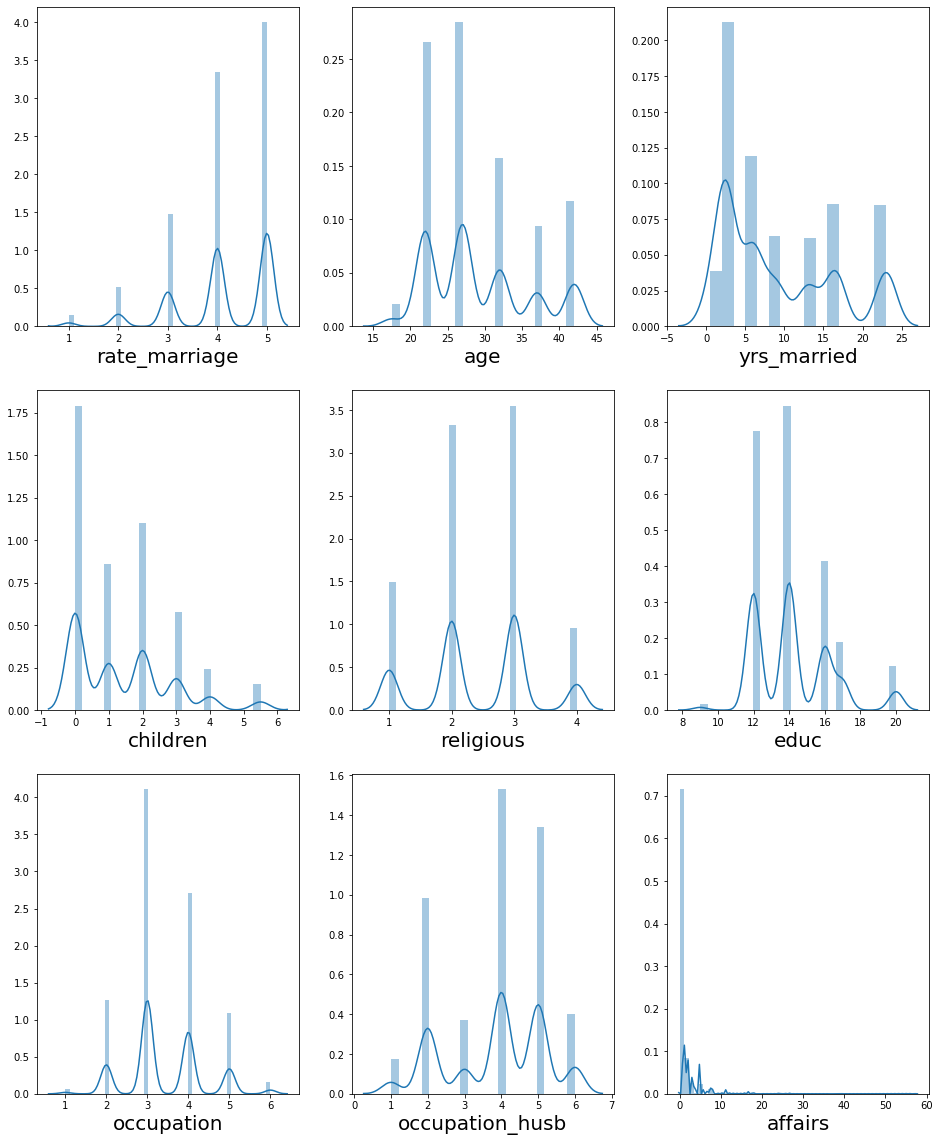

In [8]:
# let's see how data is distributed for every column
plt.figure(figsize=(16,20),facecolor='white')
plotnumber=1
for column in data:
    if plotnumber<=9:
        ax = plt.subplot(3,3,plotnumber)
        sns.distplot(data[column])
        plt.xlabel(column,fontsize=20)
    plotnumber+=1
plt.show()

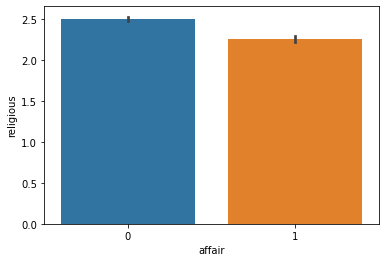

In [9]:
sns.barplot(x='affair',y='religious',data=data)

Text(0, 0.5, 'Frequency')

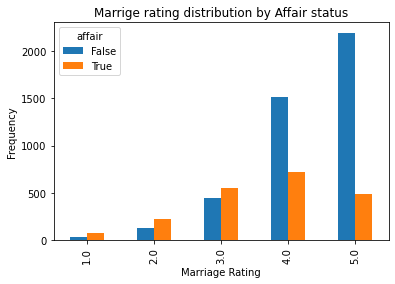

In [10]:
# Barplot of marriage rating grouped by affairs(True or False)
pd.crosstab(data.rate_marriage,data.affair.astype(bool)).plot(kind='bar')
plt.title('Marrige rating distribution by Affair status')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Text(0, 0.5, 'Percentage')

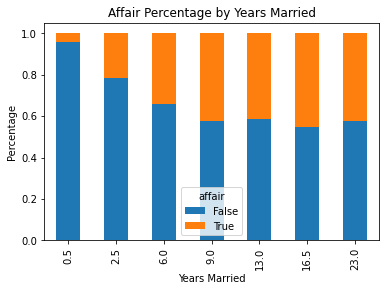

In [11]:
affair_yrs_married = pd.crosstab(data.yrs_married, data.affair.astype(bool))
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Affair Percentage by Years Married')
plt.xlabel('Years Married')
plt.ylabel('Percentage')

### Preparing dataset for applying Logistical Regression

In [12]:
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + religious + educ + C(occupation) + C(occupation_husb)', data, return_type="dataframe")

In [13]:
X

,Intercept,C(occupation)[T.2.0],C(occupation)[T.3.0],C(occupation)[T.4.0],C(occupation)[T.5.0],C(occupation)[T.6.0],C(occupation_husb)[T.2.0],C(occupation_husb)[T.3.0],C(occupation_husb)[T.4.0],C(occupation_husb)[T.5.0],C(occupation_husb)[T.6.0],rate_marriage,age,yrs_married,children,religious,educ
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,32.0,9.0,3.0,3.0,17.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,27.0,13.0,3.0,1.0,14.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,22.0,2.5,0.0,1.0,16.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,37.0,16.5,4.0,3.0,16.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,27.0,9.0,1.0,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6361,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,32.0,13.0,2.0,3.0,17.0
6362,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,32.0,13.0,1.0,1.0,16.0
6363,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,22.0,2.5,0.0,2.0,14.0
6364,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,32.0,6.0,1.0,3.0,14.0


In [14]:
y

,affair
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
6361,0.0
6362,0.0
6363,0.0
6364,0.0


In [15]:
X = X.rename(columns =
{'C(occupation)[T.2.0]':'occ_2',
'C(occupation)[T.3.0]':'occ_3',
'C(occupation)[T.4.0]':'occ_4',
'C(occupation)[T.5.0]':'occ_5',
'C(occupation)[T.6.0]':'occ_6',
'C(occupation_husb)[T.2.0]':'occ_husb_2',
'C(occupation_husb)[T.3.0]':'occ_husb_3',
'C(occupation_husb)[T.4.0]':'occ_husb_4',
'C(occupation_husb)[T.5.0]':'occ_husb_5',
'C(occupation_husb)[T.6.0]':'occ_husb_6'})

In [16]:
X

,Intercept,occ_2,occ_3,occ_4,occ_5,occ_6,occ_husb_2,occ_husb_3,occ_husb_4,occ_husb_5,occ_husb_6,rate_marriage,age,yrs_married,children,religious,educ
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,32.0,9.0,3.0,3.0,17.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,27.0,13.0,3.0,1.0,14.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,22.0,2.5,0.0,1.0,16.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,37.0,16.5,4.0,3.0,16.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,27.0,9.0,1.0,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6361,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,32.0,13.0,2.0,3.0,17.0
6362,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,32.0,13.0,1.0,1.0,16.0
6363,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,22.0,2.5,0.0,2.0,14.0
6364,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,32.0,6.0,1.0,3.0,14.0


In [17]:
y = np.ravel(y)
y

array([1., 1., 1., ..., 0., 0., 0.])

In [18]:
## Splitting the data into train and test
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 100, test_size=0.3)

In [19]:
X_train.shape

(4456, 17)

In [20]:
X_test.shape

(1910, 17)

In [21]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [22]:
y_pred = log_reg.predict(X_test)

In [23]:
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.7136125654450262

### Evaluating Model

In [24]:
## Classification report
print("Classification report ",classification_report(y_test,y_pred))

Classification report                precision    recall  f1-score   support

         0.0       0.73      0.91      0.81      1286
         1.0       0.62      0.31      0.42       624

    accuracy                           0.71      1910
   macro avg       0.68      0.61      0.61      1910
weighted avg       0.70      0.71      0.68      1910



In [25]:
## Confusion Matrix
conf_mat = confusion_matrix(y_test,y_pred)
conf_mat

array([[1167,  119],
       [ 428,  196]], dtype=int64)

In [26]:
true_positive=conf_mat[0][0]
false_positive=conf_mat[0][1]
false_negative=conf_mat[1][0]
true_negative=conf_mat[1][1]

In [27]:
# Breaking down the formula for Accuracy
Accuracy = (true_positive + true_negative) / (true_positive+true_negative+false_positive+false_negative)
Accuracy

0.7136125654450262

In [28]:
# Recall
Recall = true_positive / (true_positive+false_negative)
Recall

0.7316614420062696

In [29]:
# Precision 
Precision = true_positive / (true_positive+false_positive)
Precision

0.9074650077760498

In [30]:
#F1 score 
F1_score = 2*(Recall * Precision)/(Recall+Precision)
F1_score

0.8101353696633113

In [31]:
## Area Under Curve(AUC) 
auc = roc_auc_score(y_test, y_pred)
auc

0.6107837859393069

In [32]:
fpr,tpr,thresolds= roc_curve(y_test,y_pred)

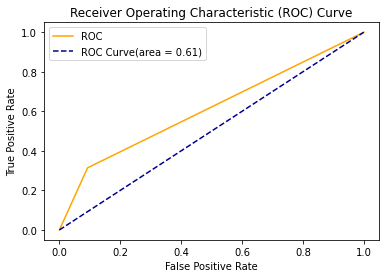

In [33]:
plt.plot(fpr,tpr,color = 'orange',label= 'ROC')
plt.plot([0,1],[0,1],color = 'darkblue',linestyle='--',label='ROC Curve(area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [34]:
scores = cross_val_score(LogisticRegression(),X,y,scoring='accuracy',cv=10)
scores

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

array([0.72370487, 0.69858713, 0.73940345, 0.70800628, 0.71428571,
       0.72684458, 0.72798742, 0.70754717, 0.75      , 0.75314465])

In [35]:
scores.mean()

0.7249511270400758